🔍 ANÁLISIS DE PUBLICACIONES: HARINA DE PLÁTANO Y ENZIMAS
📝 Ecuación de búsqueda: TITLE("Plantain" OR "banana" OR "musa") AND TITLE("flour" OR "starch") AND TITLE("enzyme" OR "glucose oxidase")

🔍 Obteniendo resultados completos...
✅ Búsqueda exitosa: 18 resultados totales
⏳ Recuperados 18 de 18 resultados (100.0%)...
✅ Recuperados 18 resultados en total

📋 TABLA DE RESULTADOS POR AÑO:
----------------------------------------
 Año  Publicaciones  Acumulado
1982              1          1
2004              1          2
2011              1          3
2017              1          4
2019              1          5
2020              4          9
2021              3         12
2022              1         13
2023              2         15
2024              3         18
----------------------------------------
Total de publicaciones: 18


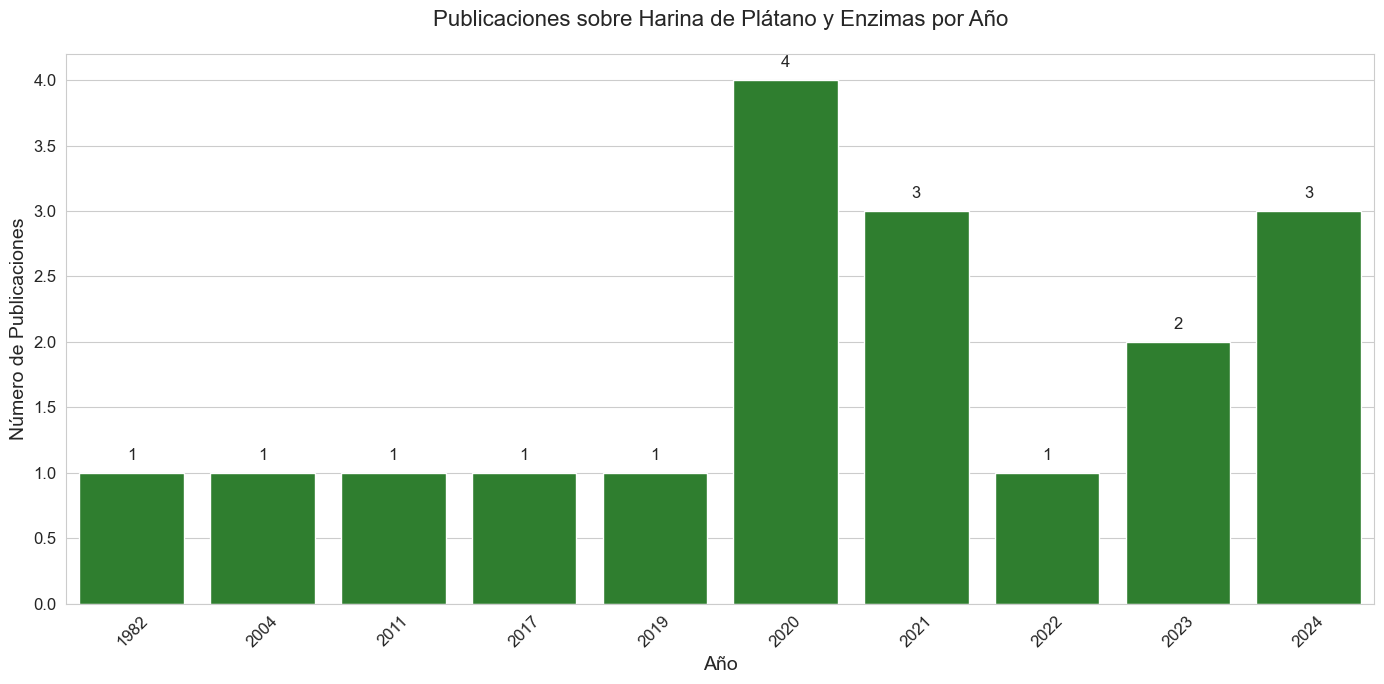

❌ Error inesperado: No such keys(s): 'mode.use_inf_as_null'


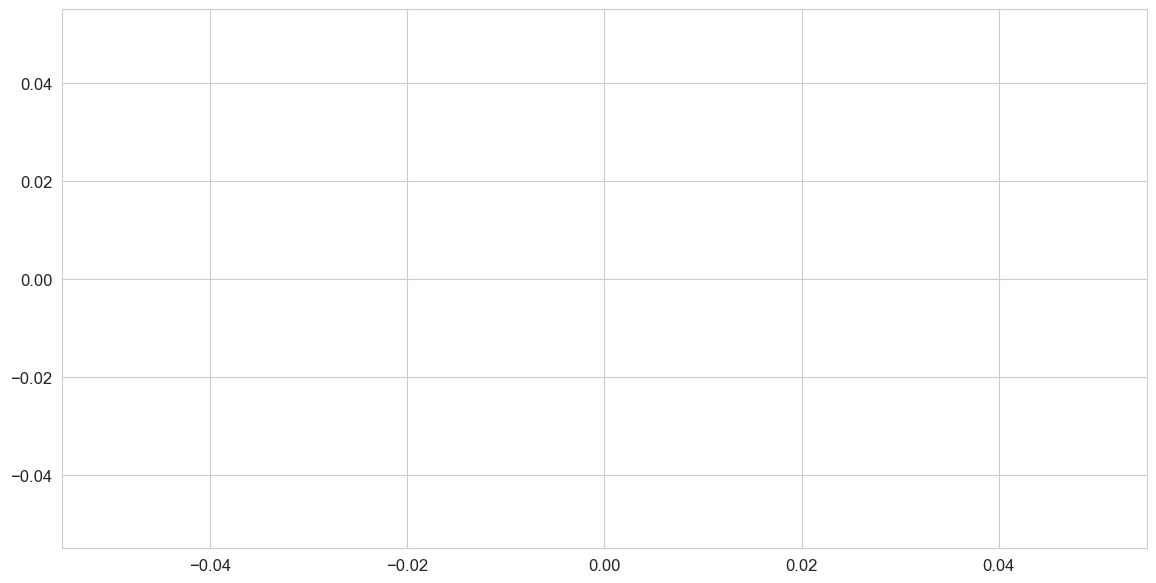

In [1]:
# Análisis de Publicaciones sobre Harina de Plátano y Enzimas por Año
# Búsqueda en Scopus API

import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
import re

# Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12

# Configuración de la API key
api_key = "113f57bcfb9e922c5a33ec02233ee24d"

def search_plantain_flour_publications():
    """
    Busca publicaciones relacionadas con harina de plátano y enzimas.
    Recopila resultados por año desde los más antiguos.
    """
    print("=" * 60)
    print("🔍 ANÁLISIS DE PUBLICACIONES: HARINA DE PLÁTANO Y ENZIMAS")
    print("=" * 60)
    
    # Corregir la ecuación de búsqueda (TITLE en lugar de TITTLE)
    query = 'TITLE("Plantain" OR "banana" OR "musa") AND TITLE("flour" OR "starch") AND TITLE("enzyme" OR "glucose oxidase")'
    
    print(f"📝 Ecuación de búsqueda: {query}")
    
    # Configurar parámetros de búsqueda
    base_url = "https://api.elsevier.com/content/search/scopus"
    headers = {
        "X-ELS-APIKey": api_key,
        "Accept": "application/json"
    }
    
    # Primero, obtener todos los resultados para conocer el rango de años
    try:
        # Verificar si la búsqueda funciona
        response = requests.get(
            base_url,
            headers=headers,
            params={"query": query, "count": 1}
        )
        
        if response.status_code != 200:
            print(f"❌ Error en la búsqueda: {response.status_code}")
            print(response.text)
            
            # Probar con una versión simplificada de la consulta para diagnosticar
            print("\n🔍 Probando con búsqueda simplificada...")
            simple_query = 'TITLE("banana") AND TITLE("flour")'
            response = requests.get(
                base_url,
                headers=headers,
                params={"query": simple_query, "count": 1}
            )
            
            if response.status_code == 200:
                print("✅ La búsqueda simplificada funciona")
                print("❗ El problema está en la complejidad de la ecuación original")
                
                # Usar la ecuación simplificada
                query = simple_query
                print(f"📝 Nueva ecuación de búsqueda: {query}")
            else:
                print(f"❌ Error también con búsqueda simplificada: {response.status_code}")
                return None
        
        # Realizar la búsqueda con la ecuación (original o simplificada)
        print("\n🔍 Obteniendo resultados completos...")
        response = requests.get(
            base_url,
            headers=headers,
            params={"query": query, "count": 25, "sort": "coverDate"}
        )
        
        if response.status_code == 200:
            data = response.json()
            total_results = int(data["search-results"]["opensearch:totalResults"])
            print(f"✅ Búsqueda exitosa: {total_results} resultados totales")
            
            if total_results == 0:
                print("❌ No se encontraron resultados con esta ecuación")
                return None
            
            # Recopilar todos los resultados
            all_results = []
            params = {"query": query, "count": 25, "start": 0, "sort": "coverDate"}
            
            while params["start"] < total_results:
                response = requests.get(base_url, headers=headers, params=params)
                
                if response.status_code == 200:
                    data = response.json()
                    entries = data["search-results"].get("entry", [])
                    all_results.extend(entries)
                    
                    print(f"⏳ Recuperados {len(all_results)} de {total_results} resultados ({(len(all_results)/total_results*100):.1f}%)...")
                    
                    params["start"] += params["count"]
                    
                    if params["start"] < total_results:
                        time.sleep(0.5)  # pequeña pausa entre solicitudes
                else:
                    print(f"❌ Error al recuperar página: {response.status_code}")
                    break
            
            print(f"✅ Recuperados {len(all_results)} resultados en total")
            
            # Analizar por año
            publications_by_year = {}
            
            for entry in all_results:
                # Intentar extraer el año
                year = None
                
                # De la fecha de cobertura
                if "prism:coverDate" in entry:
                    try:
                        date_str = entry["prism:coverDate"]
                        year = datetime.strptime(date_str, "%Y-%m-%d").year
                    except Exception:
                        pass
                
                # Del año de publicación
                if not year and "prism:publicationDate" in entry:
                    try:
                        date_str = entry["prism:publicationDate"]
                        year = datetime.strptime(date_str, "%Y-%m-%d").year
                    except Exception:
                        pass
                
                # De la fecha de cobertura (display)
                if not year and "prism:coverDisplayDate" in entry:
                    try:
                        year_str = entry["prism:coverDisplayDate"]
                        year_match = re.search(r'\b(19|20)\d{2}\b', year_str)
                        if year_match:
                            year = int(year_match.group(0))
                    except Exception:
                        pass
                
                # Si no se pudo determinar el año, continuar
                if not year:
                    continue
                
                # Incrementar contador para este año
                publications_by_year[year] = publications_by_year.get(year, 0) + 1
            
            # Crear DataFrame ordenado por año
            if publications_by_year:
                years = sorted(publications_by_year.keys())
                counts = [publications_by_year[year] for year in years]
                
                df = pd.DataFrame({
                    'Año': years,
                    'Publicaciones': counts
                })
                
                # Calcular acumulado
                df['Acumulado'] = df['Publicaciones'].cumsum()
                
                # Mostrar tabla completa
                print("\n📋 TABLA DE RESULTADOS POR AÑO:")
                print("-" * 40)
                print(df.to_string(index=False))
                print("-" * 40)
                print(f"Total de publicaciones: {df['Publicaciones'].sum()}")
                
                # Generar visualizaciones
                create_visualizations(df, query)
                
                return df
            else:
                print("❌ No se pudieron categorizar las publicaciones por año")
                return None
        else:
            print(f"❌ Error en la búsqueda: {response.status_code}")
            print(response.text)
            return None
    except Exception as e:
        print(f"❌ Error inesperado: {str(e)}")
        return None

def create_visualizations(df, query_description):
    """
    Crea visualizaciones de los datos de publicaciones.
    
    Args:
        df: DataFrame con datos por año
        query_description: Descripción de la búsqueda para títulos
    """
    title_base = "Publicaciones sobre Harina de Plátano y Enzimas"
    
    # 1. Gráfico de barras
    plt.figure(figsize=(14, 7))
    ax = sns.barplot(x='Año', y='Publicaciones', data=df, color='forestgreen')
    
    plt.title(f'{title_base} por Año', fontsize=16, pad=20)
    plt.xlabel('Año', fontsize=14)
    plt.ylabel('Número de Publicaciones', fontsize=14)
    plt.xticks(rotation=45)
    
    # Añadir etiquetas con valores
    for i, v in enumerate(df['Publicaciones']):
        ax.text(i, v + 0.1, str(v), ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Curva S (acumulativo)
    plt.figure(figsize=(14, 7))
    ax = sns.lineplot(x='Año', y='Acumulado', data=df, marker='o', markersize=8, linewidth=2, color='darkorange')
    
    plt.title(f'{title_base} - Acumulado (Curva S)', fontsize=16, pad=20)
    plt.xlabel('Año', fontsize=14)
    plt.ylabel('Publicaciones Acumuladas', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Añadir etiquetas con valores acumulados en puntos clave
    # Primer punto, punto medio y último punto
    indices = [0, len(df) // 2, -1]
    for i in indices:
        ax.text(df.index[i], df['Acumulado'].iloc[i] + 0.3, 
                str(df['Acumulado'].iloc[i]), ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Gráfico combinado
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    ax1.bar(df['Año'], df['Publicaciones'], alpha=0.6, color='forestgreen', label='Publicaciones por año')
    ax1.set_xlabel('Año', fontsize=14)
    ax1.set_ylabel('Publicaciones por Año', fontsize=14, color='forestgreen')
    ax1.tick_params(axis='y', labelcolor='forestgreen')
    
    ax2 = ax1.twinx()
    ax2.plot(df['Año'], df['Acumulado'], color='darkorange', marker='o', linewidth=2, label='Acumulado')
    ax2.set_ylabel('Publicaciones Acumuladas', fontsize=14, color='darkorange')
    ax2.tick_params(axis='y', labelcolor='darkorange')
    
    plt.title(f'{title_base}: Anual vs. Acumulado', fontsize=16, pad=20)
    fig.tight_layout()
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.show()
    
    # Preguntar si quiere exportar
    if input("\n¿Deseas exportar los resultados a CSV? (s/n): ").lower() == 's':
        filename = "harina_platano_enzimas_publicaciones.csv"
        df.to_csv(filename, index=False)
        print(f"\n✅ Datos exportados a '{filename}'")
        
        # Si estamos en Colab, ofrecer descarga
        try:
            from google.colab import files
            files.download(filename)
            print("✅ Archivo disponible para descarga")
        except ImportError:
            pass  # No estamos en Colab

# Ejecutar la búsqueda
search_plantain_flour_publications()